In [1]:
%autosave 3600

Autosaving every 3600 seconds


# Train seq2seq Model

/home/oscar/anaconda3/envs/gpuvenv/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


LSTM start learning time = 18:07:34
Train on 70092 samples, validate on 17524 samples
Epoch 1/30
70065/70092 [============================>.] - ETA: 0s - loss: 0.1701 - root_mean_squared_error: 0.4124 - mae: 0.2654 - acc: 0.0000e+00
Epoch 00001: val_loss improved from inf to 0.09281, saving model to heatLoad.model_normalized_lstm.best.hdf5
70092/70092 [==============================] - 101s 1ms/sample - loss: 0.1701 - root_mean_squared_error: 0.4124 - mae: 0.2654 - acc: 0.0000e+00 - val_loss: 0.0928 - val_root_mean_squared_error: 0.3047 - val_mae: 0.2146 - val_acc: 0.0000e+00
Epoch 2/30
70065/70092 [============================>.] - ETA: 0s - loss: 0.1011 - root_mean_squared_error: 0.3180 - mae: 0.2363 - acc: 0.0000e+00
Epoch 00002: val_loss improved from 0.09281 to 0.09100, saving model to heatLoad.model_normalized_lstm.best.hdf5
70092/70092 [==============================] - 100s 1ms/sample - loss: 0.1011 - root_mean_squared_error: 0.3180 - mae: 0.2363 - acc: 0.0000e+00 - val_loss: 0

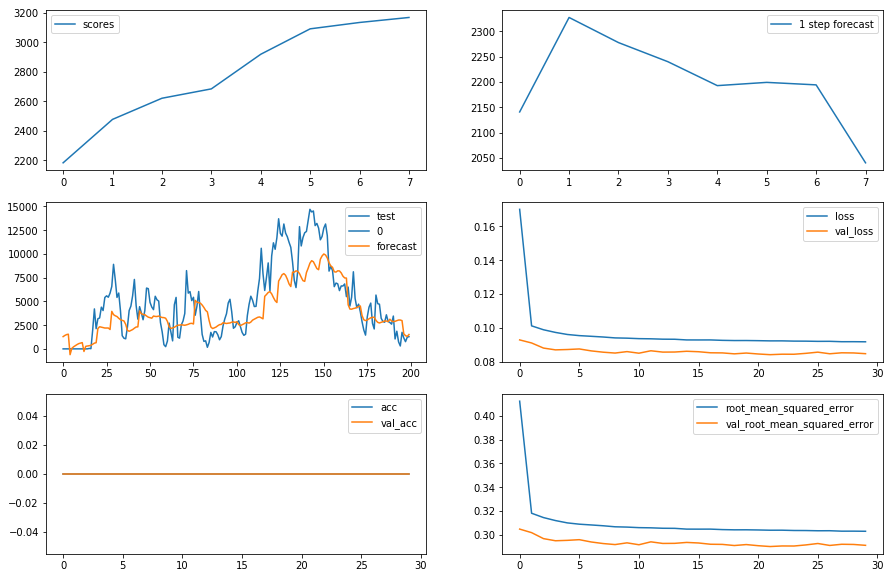

In [1]:
from sotavento import Data
from ForecastModel import Model
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from datetime import datetime
from numpy import array
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.metrics import RootMeanSquaredError

%matplotlib inline

def plott(scores, predictions, test, model):    
    a4_dims = (15, 10)
    fig, axs = plt.subplots(ncols=2, nrows = 3, figsize=a4_dims)

    scoress = array(scores)
    sns.lineplot(label="scores", data=scoress, ax=axs[0][0])

    pred = predictions.reshape((336, 8))
    sns.lineplot(label="1 step forecast", data=pred[15], ax=axs[0][1])

    pred_flat = [item for step in pred for item in step]
    test_flat = [item for step in test for item in step]
    sns.lineplot(label="test", data=array(test_flat[100:300]), ax=axs[1][0])
    sns.lineplot(label="forecast", data=array(pred_flat[100:300]), ax=axs[1][0])

    history = model.history.history
    sns.lineplot(label="loss", data=array(history['loss']), ax=axs[1][1])
    sns.lineplot(label="val_loss", data=array(history['val_loss']), ax=axs[1][1])
    
    sns.lineplot(label="acc", data=array(history['acc']), ax=axs[2][0])
    sns.lineplot(label="val_acc", data=array(history['val_acc']), ax=axs[2][0])
    
    sns.lineplot(label="root_mean_squared_error", data=array(history['root_mean_squared_error']), ax=axs[2][1])
    sns.lineplot(label="val_root_mean_squared_error", data=array(history['val_root_mean_squared_error']), ax=axs[2][1])
 
    plt.show()
    return

#Data gathering
fileName = 'Sotavento Historical Data.csv'
n_out = 8
multivariate = True

forecast = Data(fileName, multivariate)
data = forecast.dataPrep()




#Train, test data sets
startTrain = '2009'
endTrain = '2018'
startTest = '1-Jan-2019'
endTest = '2019-04-22'
if not multivariate:
    #data.drop(labels = ['wind_speed', 'wind_direction','week'], axis=1, inplace = True)
    data_x = data.loc[:, data.columns == 'energy']
    data_y = data_x #data.loc[startTrain:endTrain, data.columns = 'energy']
else:
    data_x = data.loc[:, data.columns != 'energy']
    data_y = data.loc[:, data.columns == 'energy']
    
    
train_x, test_x, train_y, test_y, scaler_x, scaler_y = forecast.split_dataset(data_x, data_y, startTrain, endTrain,
                                                                              startTest, endTest, n_out)

#MLSTM Model evaluation
n_input = 24
y_col = 2
enconderUnits = 1500
decoderUnit = 1500
denseUnit = 24
dropout = .3
learning_rate=0.00089
amsgrad = True
decay = 0.007
epochs = 30
batch_size = 45
validation_split = .2
verbose = 1


initiate_model = Model(multivariate)
try:
    session.close()
except Exception:
    pass
session = initiate_model.protoConfig()

#Convert data to supervised
train_x_sup, train_y_sup, n_timesteps, n_features, n_outputs = initiate_model.to_supervised(train_x, train_y, n_input,
                                                                                    y_col, n_out, multivariate)

print("LSTM start learning time =", datetime.now().strftime("%H:%M:%S"))
    
#Build model architecture
model = initiate_model.LSTMEncoderDecoder(enconderUnits, decoderUnit, denseUnit, 
                                          dropout, n_timesteps, n_features, n_outputs)

#compile model
model = initiate_model.modelCompile(model, learning_rate, decay, amsgrad)

#fit model
checkpointFilePath = 'heatLoad.model_normalized_lstm.best.hdf5'
model = initiate_model.modelfit(model, train_x_sup, train_y_sup, epochs, 
                                batch_size, validation_split, verbose, 
                                checkpointFilePath)

#evaluate model
score, scores, model, test_normalized, predictions_normalized = initiate_model.evaluate_model(train_x, test_x, test_y,
                                                                                              model, n_input,
                                                                                              checkpointFilePath, scaler_x, scaler_y,
                                                                                             multivariate)
                                                                                              
print("LSTM end learning time =", datetime.now().strftime("%H:%M:%S"))
                                                                                              
#summarize scores                                                                                              
initiate_model.summarize_scores('lstm', score, scores)
plott(scores, predictions_normalized, test_normalized, model)

## Evalute model with unseen data (may 2019)

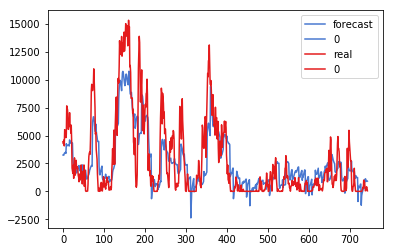

In [4]:
from numpy import split
fileName = 'Sotavento May 2019.csv'
n_out = 8
n_input = 24
y_col = 2

multivariate = True
forecast = Data(fileName, multivariate)
data = forecast.dataPrep()

if not multivariate:
    data_x = data.loc[:, data.columns == 'energy']
    data_y = data_x 
else:
    data_x = data.loc[:, data.columns != 'energy']
    data_y = data.loc[:, data.columns == 'energy']

predictions = list()
for i in range(int((len(data)/n_out)-24/n_out)): 
    start = i * n_out
    input_data = data_x[start:start+n_input]
    input_data = scaler_x.transform(input_data)
    input_data = array(split(array(input_data), len(input_data)/n_out))

    history = [x for x in input_data]


    for i in range(1):
        yhat_sequence = initiate_model.forecast(model, input_data, n_input, multivariate)
                #store the predictions
        predictions.append(yhat_sequence)
                #get real observations and add to history to predicting next week
        history.append(yhat_sequence)
        
predictions_flat = [item for step in predictions for item in step]
predictions_flat_trans = scaler_y.inverse_transform(predictions_flat)

sns.lineplot(label="forecast", data=array(predictions_flat_trans[:]), palette=sns.color_palette("muted", n_colors=1))
sns.lineplot(label="real", data=array(data_y[24:]), palette=sns.color_palette("Set1", n_colors=1))
